In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip /content/drive/MyDrive/mhealth_raw_data.csv.zip

Archive:  /content/drive/MyDrive/mhealth_raw_data.csv.zip
  inflating: mhealth_raw_data.csv    


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
import keras
 
%matplotlib inline
tf.random.set_seed(42)

In [ ]:
df = pd.read_csv('/content/mhealth_raw_data.csv')
df

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
0,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-8.6499,-4.5781,0.187760,-0.449020,-1.01030,0.034483,0,subject1
1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-8.6275,-4.3198,0.023595,-0.449020,-1.01030,0.034483,0,subject1
2,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-8.5055,-4.2772,0.275720,-0.449020,-1.01030,0.034483,0,subject1
3,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,-8.6279,-4.3163,0.367520,-0.456860,-1.00820,0.025862,0,subject1
4,2.4173,-9.3889,0.71098,0.085343,-0.83865,-0.68369,-8.7008,-4.1459,0.407290,-0.456860,-1.00820,0.025862,0,subject1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215740,1.7849,-9.8287,0.29725,-0.341370,-0.90056,-0.61493,-3.7198,-8.9071,0.294230,0.041176,-0.99384,-0.480600,0,subject10
1215741,1.8687,-9.8766,0.46236,-0.341370,-0.90056,-0.61493,-3.7160,-8.7455,0.448140,0.041176,-0.99384,-0.480600,0,subject10
1215742,1.6928,-9.9290,0.16631,-0.341370,-0.90056,-0.61493,-3.8824,-9.1155,0.450480,0.041176,-0.99384,-0.480600,0,subject10
1215743,1.5279,-9.6306,0.30458,-0.341370,-0.90056,-0.61493,-3.5564,-9.1441,0.594880,0.041176,-0.99384,-0.480600,0,subject10


In [ ]:
from sklearn.utils import resample
 
df_majority = df[df.Activity==0]
df_minorities = df[df.Activity!=0]
 
df_majority_downsampled = resample(df_majority,n_samples=30000, random_state=42)
df = pd.concat([df_majority_downsampled, df_minorities])
df.Activity.value_counts()

1     30720
2     30720
3     30720
4     30720
9     30720
10    30720
11    30720
5     30720
0     30000
7     29441
8     29337
6     28315
12    10342
Name: Activity, dtype: int64

In [ ]:
df1 = df.copy()

for feature in df1.columns[:-2]:
  lower_range = np.quantile(df[feature],0.01)
  upper_range = np.quantile(df[feature],0.99)
  print(feature,'range:',lower_range,'to',upper_range)

  df1 = df1.drop(df1[(df1[feature]>upper_range) | (df1[feature]<lower_range)].index, axis=0)
  print('shape',df1.shape)

alx range: -11.47312 to 19.233
shape (365733, 14)
aly range: -19.379 to 2.447871999999997
shape (360018, 14)
alz range: -18.95 to 14.19623999999999
shape (356270, 14)
glx range: -0.74212 to 0.80705
shape (349377, 14)
gly range: -1.0694 to 0.96623
shape (342841, 14)
glz range: -1.1061 to 0.8290799999999999
shape (337391, 14)
arx range: -21.492 to 9.097647999999998
shape (332307, 14)
ary range: -18.694000000000003 to 11.948059999999998
shape (326241, 14)
arz range: -10.367 to 11.823119999999996
shape (323674, 14)
grx range: -1.0196 to 0.95686
shape (320188, 14)
gry range: -1.1417 to 0.90965
shape (315352, 14)
grz range: -0.69828 to 1.125
shape (310929, 14)


In [ ]:
label_map = {
    0: 'Nothing',
    1: 'Standing still',  
    2: 'Sitting and relaxing', 
    3: 'Lying down',  
    4: 'Walking',  
    5: 'Climbing stairs',  
    6: 'Waist bends forward',
    7: 'Frontal elevation of arms', 
    8: 'Knees bending (crouching)', 
    9: 'Cycling', 
    10: 'Jogging', 
    11: 'Running', 
    12: 'Jump front & back' 
}

In [ ]:
train = df1[(df1['subject'] != 'subject10') & (df1['subject'] != 'subject9')]
test = df1.drop(train.index, axis=0)
train.shape,test.shape

((246501, 14), (64428, 14))

In [ ]:
X_train = train.drop(['Activity','subject'],axis=1)
y_train = train['Activity']
X_test = test.drop(['Activity','subject'],axis=1)
y_test = test['Activity']
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((246501, 12), (246501,), (64428, 12), (64428,))

In [ ]:
from scipy import stats

#function to create time series datset for seuence modeling
def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [ ]:
X_train,y_train = create_dataset(X_train, y_train, 100, step=50)
X_train.shape, y_train.shape

((4929, 100, 12), (4929, 1))

In [ ]:
X_test,y_test = create_dataset(X_test, y_test, 100, step=50)
X_test.shape, y_test.shape

((1287, 100, 12), (1287, 1))

In [ ]:
model = keras.Sequential()
model.add(layers.Input(shape=[100,12]))
model.add(layers.Conv1D(filters=16, kernel_size=4, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Conv1D(filters=32, kernel_size=4, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPool1D(2))
model.add(layers.LSTM(64))
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(13, activation='softmax'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_35 (Conv1D)          (None, 100, 16)           784       
                                                                 
 batch_normalization_35 (Bat  (None, 100, 16)          64        
 chNormalization)                                                
                                                                 
 re_lu_35 (ReLU)             (None, 100, 16)           0         
                                                                 
 conv1d_36 (Conv1D)          (None, 100, 32)           2080      
                                                                 
 batch_normalization_36 (Bat  (None, 100, 32)          128       
 chNormalization)                                                
                                                                 
 re_lu_36 (ReLU)             (None, 100, 32)         

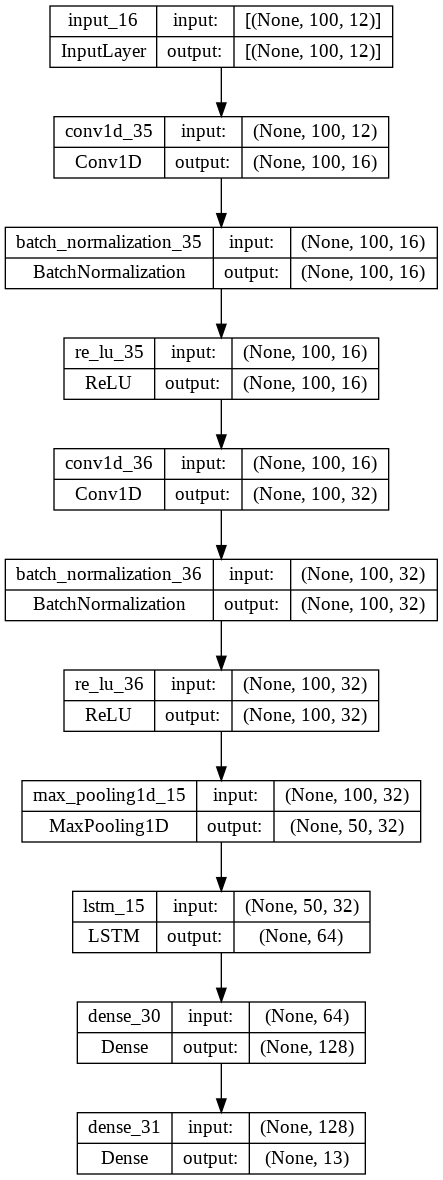

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint("mhealth_best.h5", save_best_only=True, monitor="val_loss"),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1)]
 
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"],)
 
model_history = model.fit(X_train,y_train, epochs= 10, validation_data=(X_test,y_test), callbacks=callbacks)

Epoch 1/10
155/155 [==============================] - 10s 45ms/step - loss: 0.9042 - sparse_categorical_accuracy: 0.7253 - val_loss: 1.9098 - val_sparse_categorical_accuracy: 0.5035
Epoch 2/10
155/155 [==============================] - 6s 40ms/step - loss: 0.2392 - sparse_categorical_accuracy: 0.9304 - val_loss: 0.8409 - val_sparse_categorical_accuracy: 0.8026
Epoch 3/10
155/155 [==============================] - 8s 51ms/step - loss: 0.2361 - sparse_categorical_accuracy: 0.9229 - val_loss: 0.5900 - val_sparse_categorical_accuracy: 0.8376
Epoch 4/10
155/155 [==============================] - 6s 40ms/step - loss: 0.1557 - sparse_categorical_accuracy: 0.9515 - val_loss: 0.5256 - val_sparse_categorical_accuracy: 0.9355
Epoch 5/10
155/155 [==============================] - 6s 40ms/step - loss: 0.1587 - sparse_categorical_accuracy: 0.9560 - val_loss: 0.5387 - val_sparse_categorical_accuracy: 0.8928
Epoch 6/10
155/155 [==============================] - 6s 42ms/step - loss: 0.1065 - sparse_cat

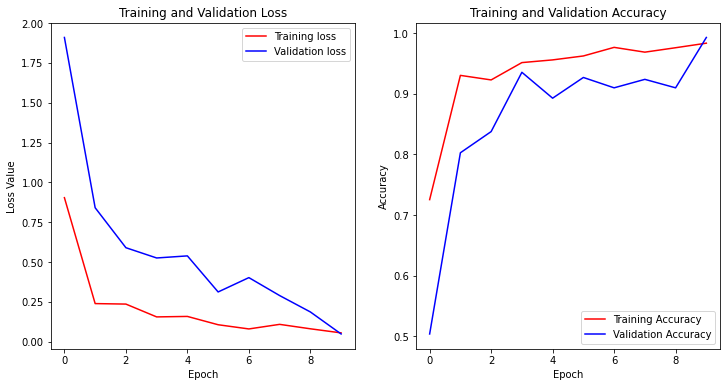

In [ ]:
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
train_accuracy = model_history.history['sparse_categorical_accuracy']
val_accuracy = model_history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
model = keras.models.load_model('./mhealth_best.h5')

train_loss, train_acc = model.evaluate(X_train,y_train)
test_loss, test_acc = model.evaluate(X_test,y_test)

print("Train accuracy", round(train_acc*100, 2),'%')
print("Train loss", train_loss)
print("Test accuracy", round(test_acc*100, 2),'%')
print("Test loss", test_loss)

41/41 [==============================] - 1s 12ms/step - loss: 0.0485 - sparse_categorical_accuracy: 0.9930
Train accuracy 99.21 %
Train loss 0.02767406590282917
Test accuracy 99.3 %
Test loss 0.0484878309071064


In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 1)
pred = pred.reshape(-1,1)
pred.shape,y_test.shape

41/41 [==============================] - 1s 11ms/step


((1287, 1), (1287, 1))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
 
print(classification_report(y_test,pred))
print('*'*50)
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        92
           1       0.99      0.99      0.99       123
           2       0.99      1.00      1.00       123
           3       1.00      1.00      1.00       122
           4       0.98      1.00      0.99       120
           5       0.99      1.00      0.99        84
           6       1.00      0.97      0.99       106
           7       1.00      0.99      1.00       112
           8       0.99      0.99      0.99       116
           9       1.00      0.99      1.00       121
          10       0.98      1.00      0.99        89
          11       0.98      0.98      0.98        52
          12       1.00      0.96      0.98        27

    accuracy                           0.99      1287
   macro avg       0.99      0.99      0.99      1287
weighted avg       0.99      0.99      0.99      1287

**************************************************
[[ 92   0   0   0   0   0   

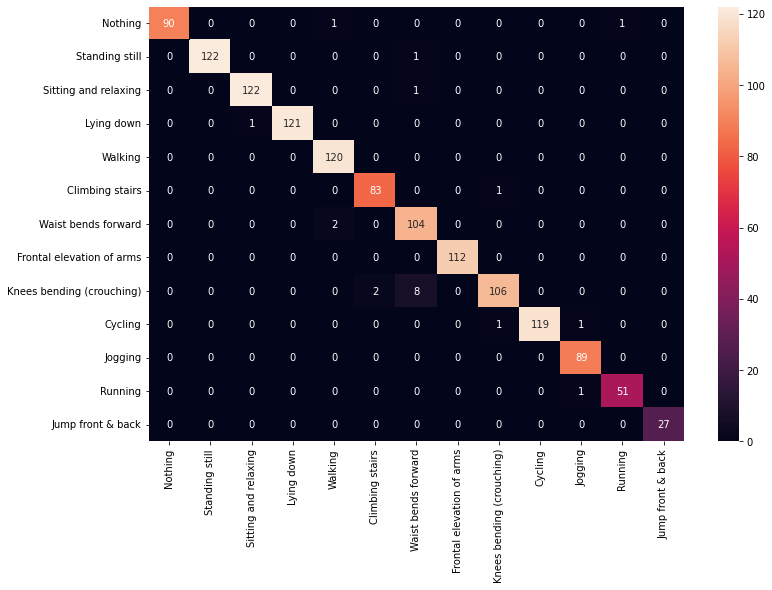

In [ ]:
plt.figure(figsize=(12,8))
conf_matrix = confusion_matrix(y_test,pred)
sns.heatmap(conf_matrix, xticklabels= label_map.values(), yticklabels= label_map.values(), annot=True, fmt="d")
plt.show()